## Διαχωρίσιμα φίλτρα εικόνας

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from time import time


In [2]:
def create_gaussian_kernel_2d(size, sigma):
    """
    Create a 2D Gaussian kernel directly
    """
    # Ensure size is odd
    if size % 2 == 0:
        size += 1

    # Create 2D coordinates
    x = np.linspace(-(size//2), size//2, size)
    y = np.linspace(-(size//2), size//2, size)
    X, Y = np.meshgrid(x, y)

    # Calculate 2D Gaussian
    gaussian = (1/(2*np.pi*sigma**2)) * np.exp(-(X**2 + Y**2)/(2*sigma**2))

    # Normalize
    return gaussian / gaussian.sum()

def create_gaussian_kernel_separable(size, sigma):
    """
    Create separable 1D Gaussian kernels
    """
    # Ensure size is odd
    if size % 2 == 0:
        size += 1

    # Create 1D coordinates
    x = np.linspace(-(size//2), size//2, size)

    # Calculate 1D Gaussian
    gaussian_1d = (1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-(x**2)/(2*sigma**2))

    # Normalize
    gaussian_1d = gaussian_1d / gaussian_1d.sum()

    return gaussian_1d

def verify_separability(kernel_2d, kernel_1d):
    """
    Verify that the 2D kernel is indeed separable by comparing
    the outer product of 1D kernels with the direct 2D kernel
    """
    # Create 2D kernel from outer product of 1D kernels
    separable_2d = np.outer(kernel_1d, kernel_1d)

    # Compare with direct 2D kernel
    difference = np.abs(kernel_2d - separable_2d)
    max_diff = np.max(difference)

    return max_diff, separable_2d



## Σύγκριση διαχωρίσιμων φίλτρων

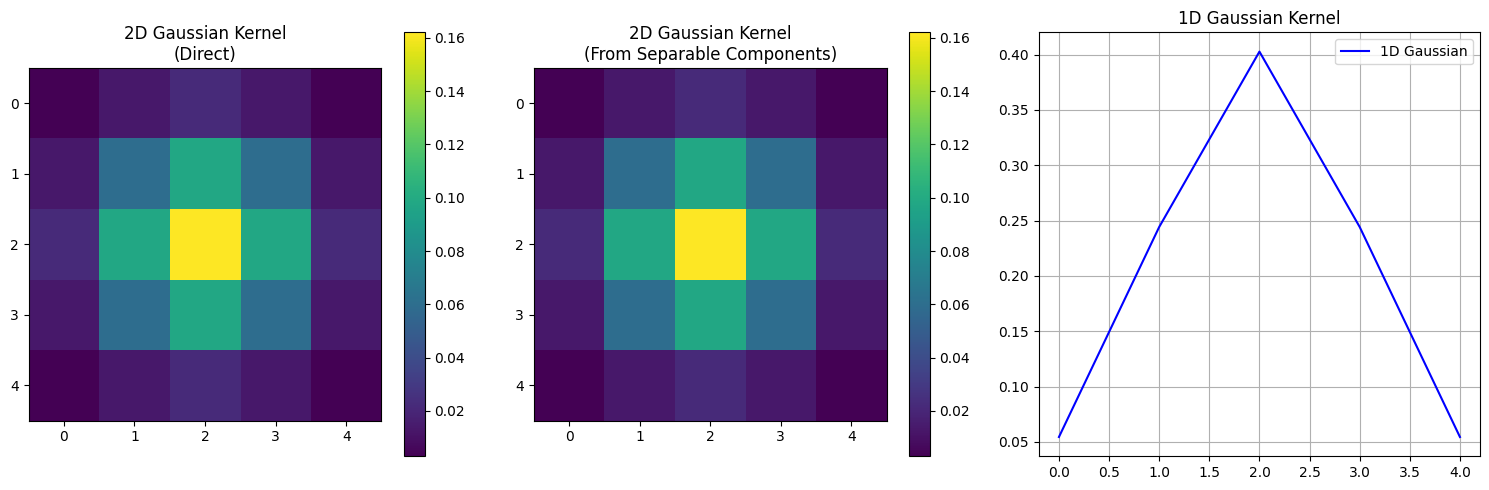

1D Gaussian Kernel (5x1):
[0.0545 0.2442 0.4026 0.2442 0.0545]

2D Gaussian Kernel (5x5):
[[0.003  0.0133 0.0219 0.0133 0.003 ]
 [0.0133 0.0596 0.0983 0.0596 0.0133]
 [0.0219 0.0983 0.1621 0.0983 0.0219]
 [0.0133 0.0596 0.0983 0.0596 0.0133]
 [0.003  0.0133 0.0219 0.0133 0.003 ]]

Maximum difference between direct and separable: 1.3877787807814457e-17


In [3]:
# Create kernels
size = 5
sigma = 1.0

# Generate both 2D and separable 1D kernels
kernel_2d = create_gaussian_kernel_2d(size, sigma)
kernel_1d = create_gaussian_kernel_separable(size, sigma)

# Verify separability
max_diff, reconstructed_2d = verify_separability(kernel_2d, kernel_1d)

# Visualization
plt.figure(figsize=(15, 5))

# Plot 2D kernel
plt.subplot(131)
plt.imshow(kernel_2d, cmap='viridis')
plt.title('2D Gaussian Kernel\n(Direct)')
plt.colorbar()

# Plot reconstructed 2D kernel
plt.subplot(132)
plt.imshow(reconstructed_2d, cmap='viridis')
plt.title('2D Gaussian Kernel\n(From Separable Components)')
plt.colorbar()

# Plot 1D kernel
plt.subplot(133)
plt.plot(kernel_1d, 'b-', label='1D Gaussian')
plt.title('1D Gaussian Kernel')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Print example kernels
print("1D Gaussian Kernel (5x1):")
print(np.round(kernel_1d, 4))
print("\n2D Gaussian Kernel (5x5):")
print(np.round(kernel_2d, 4))
print("\nMaximum difference between direct and separable:", max_diff)



In [4]:
# Example of computational advantage
def compare_operations(image_size, kernel_size):
    """
    Compare number of operations for separable vs non-separable filters
    """
    # For non-separable filter
    ops_non_separable = image_size[0] * image_size[1] * kernel_size[0] * kernel_size[1]

    # For separable filter
    ops_separable = image_size[0] * image_size[1] * (kernel_size[0] + kernel_size[1])

    return ops_non_separable, ops_separable

# Compare operations for a 1000x1000 image with 5x5 kernel
image_size = (1000, 1000)
kernel_size = (5, 5)
ops_non_sep, ops_sep = compare_operations(image_size, kernel_size)

print(f"\nComputational comparison for {image_size[0]}x{image_size[1]} image with {kernel_size[0]}x{kernel_size[1]} kernel:")
print(f"Non-separable operations: {ops_non_sep:,}")
print(f"Separable operations: {ops_sep:,}")
print(f"Speed-up factor: {ops_non_sep/ops_sep:.2f}x")


Computational comparison for 1000x1000 image with 5x5 kernel:
Non-separable operations: 25,000,000
Separable operations: 10,000,000
Speed-up factor: 2.50x


## Διαχωρίσιμα / Μη-διαχωρίσιμα φίλτρα

In [5]:
def create_gaussian_kernel_1d(size, sigma):
    """
    Create 1D Gaussian kernel
    """
    x = np.linspace(-(size//2), size//2, size)
    kernel = np.exp(-x**2/(2*sigma**2))
    return kernel / kernel.sum()

def apply_separable_filter(image, kernel_1d):
    """
    Apply separable filter using 1D kernel
    First horizontally, then vertically
    """
    # Apply horizontal filter
    intermediate = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        intermediate[i, :] = np.convolve(image[i, :], kernel_1d, mode='same')

    # Apply vertical filter
    result = np.zeros_like(image, dtype=np.float32)
    for j in range(image.shape[1]):
        result[:, j] = np.convolve(intermediate[:, j], kernel_1d, mode='same')

    return result

def apply_non_separable_filter(image, kernel_2d):
    """
    Apply 2D filter directly
    """
    return cv2.filter2D(image, -1, kernel_2d)

def compare_filtering_methods(image, kernel_size=5, sigma=1.0):
    """
    Compare separable and non-separable filtering
    """
    # Create kernels
    kernel_1d = create_gaussian_kernel_1d(kernel_size, sigma)
    kernel_2d = np.outer(kernel_1d, kernel_1d)

    # Time separable filtering
    start_time = time()
    separable_result = apply_separable_filter(image, kernel_1d)
    separable_time = time() - start_time

    # Time non-separable filtering
    start_time = time()
    non_separable_result = apply_non_separable_filter(image, kernel_2d)
    non_separable_time = time() - start_time

    return (separable_result, non_separable_result,
            separable_time, non_separable_time)

def create_test_image(size=(400, 400)):
    """
    Create a test image with various patterns
    """
    image = np.zeros(size)

    # Add some patterns
    x, y = np.meshgrid(np.linspace(0, 1, size[1]), np.linspace(0, 1, size[0]))

    # Circular pattern
    center_x, center_y = size[0]/2, size[1]/2
    distance = np.sqrt((x*size[1] - center_x)**2 + (y*size[0] - center_y)**2)
    image += np.sin(distance/10)*50 + 128

    # Add some noise
    noise = np.random.normal(0, 25, size)
    image += noise

    return np.clip(image, 0, 255).astype(np.uint8)

def plot_results(original, separable_result, non_separable_result,
                separable_time, non_separable_time):
    """
    Plot original image and filtering results
    """
    plt.figure(figsize=(15, 10))

    # Original image
    plt.subplot(231)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Separable filter result
    plt.subplot(232)
    plt.imshow(separable_result, cmap='gray')
    plt.title(f'Separable Filter\nTime: {separable_time:.3f}s')
    plt.axis('off')

    # Non-separable filter result
    plt.subplot(233)
    plt.imshow(non_separable_result, cmap='gray')
    plt.title(f'Non-separable Filter\nTime: {non_separable_time:.3f}s')
    plt.axis('off')

    # Difference image
    plt.subplot(234)
    difference = np.abs(separable_result - non_separable_result)
    plt.imshow(difference, cmap='hot')
    plt.title(f'Difference\nMax diff: {np.max(difference):.6f}')
    plt.axis('off')

    # Plot horizontal line profile
    plt.subplot(235)
    mid_row = original.shape[0]//2
    plt.plot(original[mid_row, :], 'k-', label='Original', alpha=0.5)
    plt.plot(separable_result[mid_row, :], 'b-', label='Separable')
    plt.plot(non_separable_result[mid_row, :], 'r--', label='Non-separable')
    plt.title('Horizontal Line Profile')
    plt.legend()
    plt.grid(True)

    # Plot vertical line profile
    plt.subplot(236)
    mid_col = original.shape[1]//2
    plt.plot(original[:, mid_col], 'k-', label='Original', alpha=0.5)
    plt.plot(separable_result[:, mid_col], 'b-', label='Separable')
    plt.plot(non_separable_result[:, mid_col], 'r--', label='Non-separable')
    plt.title('Vertical Line Profile')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    return plt



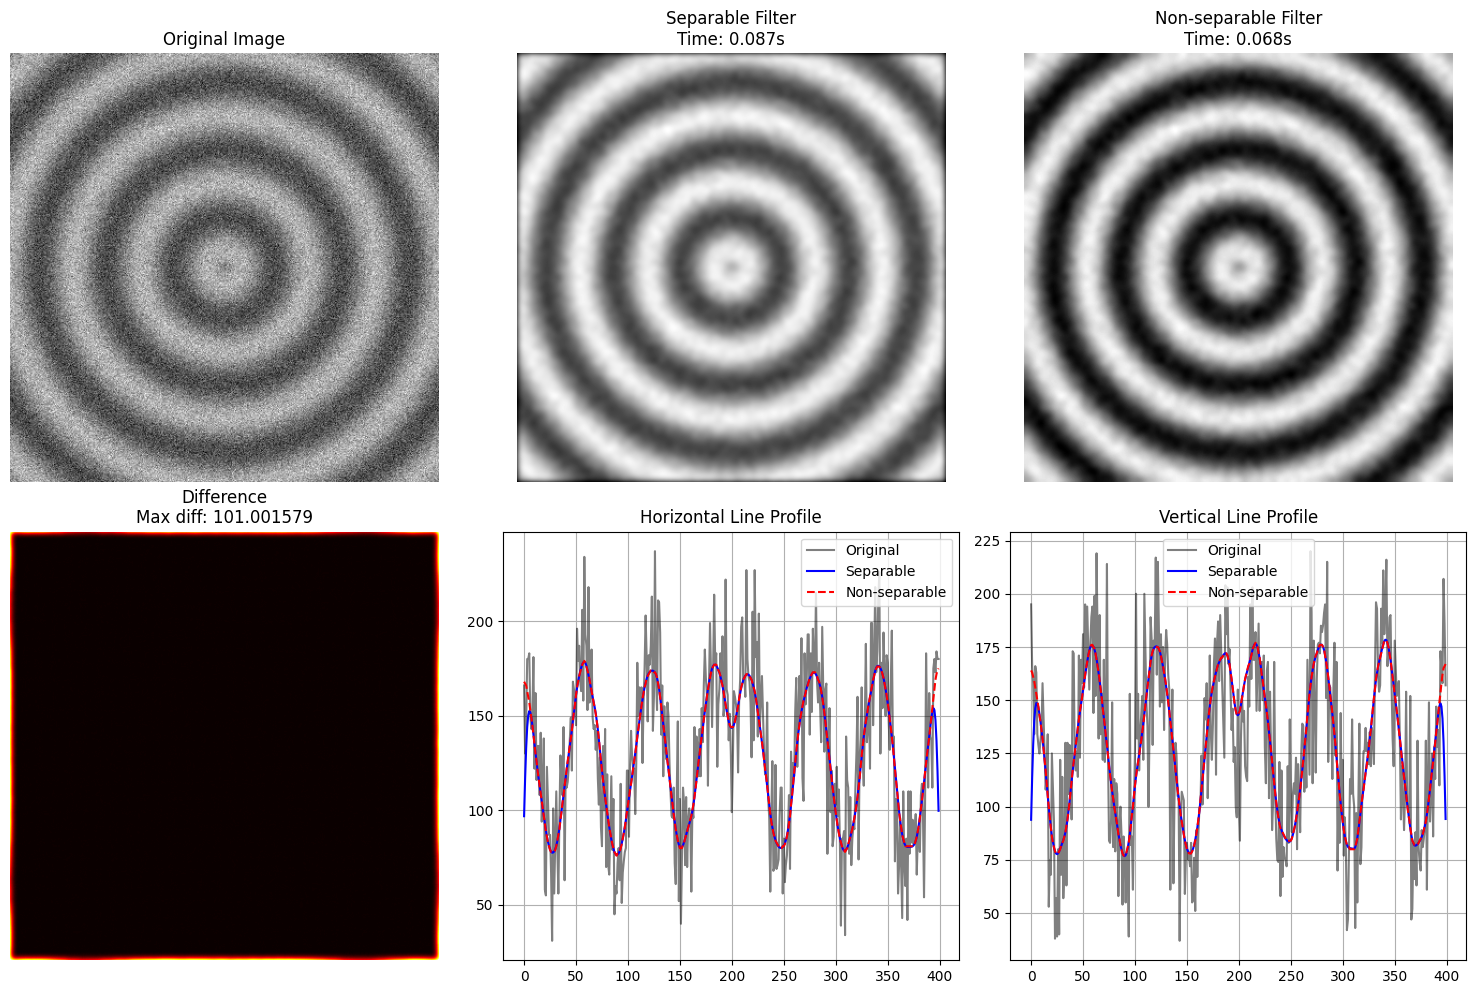


Timing Comparison (kernel size: 15x15):
Separable filtering time: 0.087 seconds
Non-separable filtering time: 0.068 seconds
Speed-up factor: 0.79x


In [6]:
# Create test image and apply filters
image = create_test_image()
kernel_size = 15  # Larger kernel to make the effect more visible
sigma = 3.0

results = compare_filtering_methods(image, kernel_size, sigma)
separable_result, non_separable_result, separable_time, non_separable_time = results

# Plot results
plot_results(image, separable_result, non_separable_result,
            separable_time, non_separable_time)
plt.show()

# Print timing comparison
print(f"\nTiming Comparison (kernel size: {kernel_size}x{kernel_size}):")
print(f"Separable filtering time: {separable_time:.3f} seconds")
print(f"Non-separable filtering time: {non_separable_time:.3f} seconds")
print(f"Speed-up factor: {non_separable_time/separable_time:.2f}x")